## Twitter Sentiment Analysis
#### References:
* Training the NaiveBayesClassifier - https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk#step-1-%E2%80%94-installing-nltk-and-downloading-the-data

#### What I would do to improve analysis:
* Intent analysis - find the user's intention behind the tweet
* Analyze larger tweet datasets
* Lemmatize words like "Hi" and "Hiiiii"
* Detect sarcasm in tweet
* Sentiment analysis API service: https://www.paralleldots.com/sentiment-analysis

In [73]:
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer  #lemmatize text (running=run)
from nltk.tag import pos_tag  #assign positional tags to tokens (noun, verb, adjective)
import re, string  #filter regular expressions
from nltk import NaiveBayesClassifier  # classifier algorithm
from nltk import classify  #classify tweets as positive or negative
from nltk import FreqDist  #determine the most frequent words in analysis
from nltk.tokenize import word_tokenize  #tokenize words
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tweepy
import warnings
warnings.filterwarnings("ignore")
from config import api_key, secret_api_key, access_token, secret_access_token

In [74]:
# viewing json files inside twitter_samples data
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

### Analyzing twitter corpus for bias

In [75]:
# combining NLTK positive and negative datasets
user_created_at = [i["user"]["created_at"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["created_at"] for i in twitter_samples.docs("negative_tweets.json")]
user_language = [i["user"]["lang"] for i in twitter_samples.docs("positive_tweets.json")] + [i["lang"] for i in twitter_samples.docs("negative_tweets.json")]
user_followers_count = [i["user"]["followers_count"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["followers_count"] for i in twitter_samples.docs("negative_tweets.json")]
user_status_count = [i["user"]["statuses_count"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["statuses_count"] for i in twitter_samples.docs("negative_tweets.json")]
user_friend_count = [i["user"]["friends_count"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["friends_count"] for i in twitter_samples.docs("negative_tweets.json")]
user_verified = [i["user"]["verified"] for i in twitter_samples.docs("positive_tweets.json")] + [i["user"]["verified"] for i in twitter_samples.docs("negative_tweets.json")]
corpus_tweets = [i["text"] for i in twitter_samples.docs("positive_tweets.json")] + [i["text"] for i in twitter_samples.docs("negative_tweets.json")]

# creating dataframe
corpus_df = pd.DataFrame({
    "user_created_at":user_created_at,
    "user_language":user_language,
    "user_followers_count":user_followers_count,
    "user_status_count":user_status_count,
    "user_friend_count":user_friend_count,
    "user_verified":user_verified,
    "tweet":corpus_tweets
})

corpus_df.head()

,user_created_at,user_language,user_followers_count,user_status_count,user_friend_count,user_verified,tweet
0,Thu Feb 18 13:18:49 +0000 2010,fr,3683,12858,1505,False,#FollowFriday @France_Inte @PKuchly57 @Milipol...
1,Mon Feb 09 14:30:33 +0000 2009,en,22528,13135,834,False,@Lamb2ja Hey James! How odd :/ Please call our...
2,Mon Aug 23 12:16:57 +0000 2010,en,187,1335,482,False,@DespiteOfficial we had a listen last night :)...
3,Tue Jul 24 20:38:16 +0000 2012,fr,3231,39809,1052,False,@97sides CONGRATS :)
4,Tue Jul 29 11:52:14 +0000 2014,en,398,2887,56,False,yeaaaah yippppy!!! my accnt verified rqst has...


In [76]:
# establishing connection to twitter api
auth = tweepy.OAuthHandler(api_key, secret_api_key)
auth.set_access_token(access_token, secret_access_token)
api = tweepy.API(auth)

# requesting API
response = api.search(q="all",count=100,tweet_mode="extended")

# compiling data
api_df = pd.DataFrame({
    "user_created_at":[i.user.created_at for i in response],
    "user_language":[i.lang for i in response],
    "user_followers_count":[i.user.followers_count for i in response],
    "user_status_count":[i.user.statuses_count for i in response],
    "user_friend_count":[i.user.friends_count for i in response],
    "user_verified":[i.user.verified for i in response],
    "tweet":[i.full_text for i in response]
})
api_df.head()

,user_created_at,user_language,user_followers_count,user_status_count,user_friend_count,user_verified,tweet
0,2012-02-09 14:54:32,en,1974,5268,487,False,RT @KyAuditorHarmon: Did you miss my interview...
1,2019-06-14 04:48:46,en,296,9357,274,False,There’s this restroom I keep having dreams abo...
2,2020-08-04 02:39:17,en,60,83,76,False,RT @puresunoo: some ppl should understand that...
3,2017-04-05 06:42:30,en,145,1254,315,False,RT @Shomilverma1: So strange we all students h...
4,2019-06-23 22:16:49,en,0,191,2,False,@atletienglish @Simeone It's time for someone ...


In [87]:
# top 5 languages and tweet counts
corpus_df["user_language"].value_counts()[:5]

en       9261
en-gb     171
id        100
fr         96
de         75
Name: user_language, dtype: int64

#### Model vocabulary
* The model is trained to classify tweets in english
* It cannot accuratly classify tweets in any other language

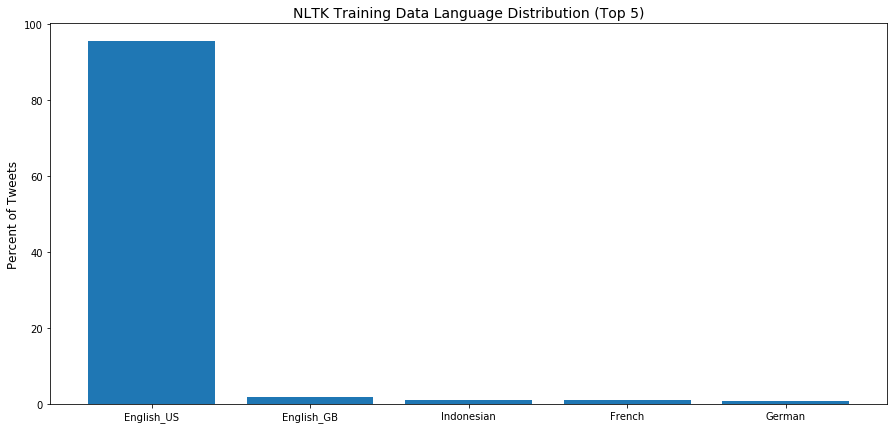

In [85]:
# converting language counts to percentage
counts = corpus_df["user_language"].value_counts()[:5]
total = counts.sum()
points = []
for i in counts:
    percent = round(i/total*100,2)
    points.append(percent)
    
# plotting
labels = ["English_US","English_GB","Indonesian","French","German"]
plt.figure(figsize=(15,7))
plt.bar(np.arange(5),points)
plt.xticks(np.arange(5),labels)
plt.title("NLTK Training Data Language Distribution (Top 5)", size=14)
plt.ylabel("Percent of Tweets",size=12)
plt.show()

In [ ]:
# calculating means across corpus and real-time tweets
api_avg_followers = api_df["user_followers_count"].mean()
corpus_avg_followers = corpus_df["user_followers_count"].mean()
api_avg_statuses = api_df["user_status_count"].mean()
corpus_avg_statuses = corpus_df["user_status_count"].mean()
api_avg_friend_count = api_df["user_friend_count"].mean()
corpus_avg_friend_count = corpus_df["user_friend_count"].mean()
api_avg_user_verified = len(api_df.loc[api_df["user_verified"]=="True"])
corpus_avg_user_verified = len(corpus_df.loc[corpus_df["user_verified"]=="True"])
api = [api_avg_followers,api_avg_statuses,api_avg_friend_count,api_avg_user_verified]
corpus = [corpus_avg_followers, corpus_avg_statuses, corpus_avg_friend_count, corpus_avg_user_verified]

#### User profile similarities
* User profile characteristics of 100 real-time tweets are compared with NLTK training data
* Similar distribution of user profile characteristics shows the NLTK data accuratly describes the average twitter user

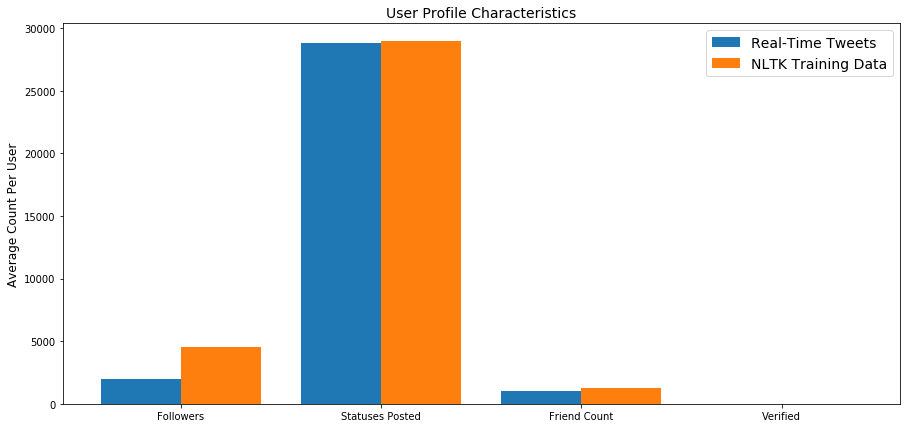

In [88]:
# plotting
x_values = np.arange(4)
labels = ["Followers","Statuses Posted","Friend Count","Verified"]
width = 0.4
plt.figure(figsize=(15,7))
plt.bar(x_values, api , width, label="Real-Time Tweets")
plt.bar(x_values + width, corpus, width, label="NLTK Training Data")
plt.xticks(x_values+width/2,labels)
plt.legend(loc="best",prop={'size': 14})
plt.ylabel("Average Count Per User", size=12)
plt.title("User Profile Characteristics",size=14)
plt.show()

In [79]:
# converting tweets into one large string value
api_tweets = api_df['tweet'].str.lower().str.cat(sep=' ')
corpus_tweets = corpus_df['tweet'].sample(100).str.lower().str.cat(sep=' ')

# normalizing the data
stop_words=set(stopwords.words('english'))

api_tokenize=word_tokenize(api_tweets)
corpus_tokenize=word_tokenize(corpus_tweets)

api_alpha_tokenize=[word for word in api_tokenize if word.isalpha()]
corpus_alpha_tokenize=[word for word in corpus_tokenize if word.isalpha()]

api_filtered_tokenize=[word for word in api_alpha_tokenize if not word in stop_words and word != "rt"]
corpus_filtered_tokenize=[word for word in corpus_alpha_tokenize if not word in stop_words and word != "rt"]

# creating dictionary with keys=keywords and values=number_of_keyword_mentions 
api_term_freq={}
for token in api_filtered_tokenize:
    if token in api_term_freq: 
        api_term_freq[token]+=1
    else: 
        api_term_freq[token]=1

corpus_term_freq={}
for token in corpus_filtered_tokenize: 
    if token in corpus_term_freq: 
        corpus_term_freq[token]+=1
    else: 
        corpus_term_freq[token]=1

api_sort_freq=sorted(api_term_freq.items(), key=lambda x: x[1], reverse=True)
corpus_sort_freq=sorted(corpus_term_freq.items(), key=lambda x: x[1], reverse=True)

# finding top terms
api_top_terms_freq=api_sort_freq[:20]
corpus_top_terms_freq=corpus_sort_freq[:20]

api_top_terms_dict={}
for each_term_freq in api_top_terms_freq: 
    if type(each_term_freq[0])==tuple: 
        api_top_terms_dict[' '.join(each_term_freq[0])]=each_term_freq[1]
    else: 
        api_top_terms_dict[each_term_freq[0]]=each_term_freq[1]

corpus_top_terms_dict={}
for each_term_freq in corpus_top_terms_freq: 
    if type(each_term_freq[0])==tuple: 
        corpus_top_terms_dict[' '.join(each_term_freq[0])]=each_term_freq[1]
    else: 
        corpus_top_terms_dict[each_term_freq[0]]=each_term_freq[1]

# converting top terms to series for plotting
api_series = pd.Series(api_top_terms_dict,index=api_top_terms_dict.keys())
corpus_series = pd.Series(corpus_top_terms_dict,index=corpus_top_terms_dict.keys())

#### Term frequency
* Comparing the top 20 most used words in the NLTK twitter corpus vs random real-time tweets

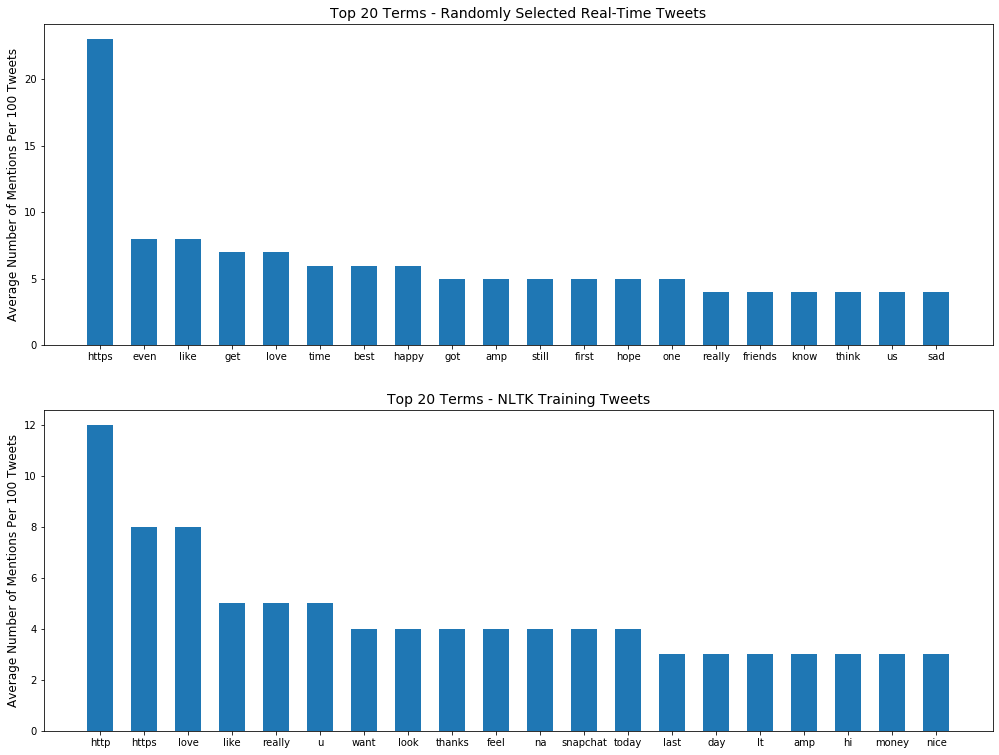

In [84]:
# plotting 
fig, [ax1,ax2] = plt.subplots(2,1, figsize=(17,13))
# twitter api
x_values_api = np.arange(len(api_series))
labels_api = [i for i in api_series.index]
ax1.bar(x_values_api,api_series,width=.6)
ax1.set_xticks(x_values_api)
ax1.set_xticklabels(labels_api)
ax1.set_ylabel("Average Number of Mentions Per 100 Tweets",size=12)
ax1.set_title("Top 20 Terms - Randomly Selected Real-Time Tweets",size=14)
# corpus 
x_values_corpus = np.arange(len(api_series))
labels_corpus = [i for i in corpus_series.index]
ax2.bar(x_values_corpus,corpus_series,width=.6)
ax2.set_xticks(x_values_corpus)
ax2.set_xticklabels(labels_corpus)
ax2.set_ylabel("Average Number of Mentions Per 100 Tweets",size=12)
ax2.set_title("Top 20 Terms - NLTK Training Tweets",size=14)
plt.show()

### Training the NaiveBayesClassifier algorithm

In [81]:
# remove undesired text from tokens (puncuation, numbers & symbols, stop words)
def clean_data(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # removing unwanted symbols and patterns from tokens using regular expressions
        token = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+","", token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        # assigning new pos tags for WordNetLemmatizer() function
        if tag.startswith("NN"):
            pos = "n"
        elif tag.startswith("VB"):
            pos = "v"
        else:
            pos = "a"
            
        # lemmatizing tokens (running=run)
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        
        # dropping puncuation and stop words
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens
            
# covert list to dictionary with keys=tokens and values=true
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

#### Tokenizing, cleaning and assembling the dataset

In [4]:
# tokenizing positive/negative tweets
positive_tokens = twitter_samples.tokenized("positive_tweets.json")
negative_tokens = twitter_samples.tokenized("negative_tweets.json")

# cleaning and prepping tokens for analysis
positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []
for tokens in positive_tokens:
    positive_cleaned_tokens_list.append(clean_data(tokens, stop_words))
for tokens in negative_tokens:
    negative_cleaned_tokens_list.append(clean_data(tokens, stop_words))

In [5]:
# converting lists of tokens to dictionaries with keys=tokens and values=True
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

# creating dataset with assigned positive and negative setiment values
positive_dataset = [(tweet_dict, "Positive") for tweet_dict in positive_tokens_for_model]
negative_dataset = [(tweet_dict, "Negative") for tweet_dict in negative_tokens_for_model]

# combining and shuffling positive and negative datasets 
dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

# splitting dataset into train/test data
train_data = dataset[:7000]
test_data = dataset[7000:]

#### Training and testing the NaiveBayesClassifier

In [6]:
# training the NaiveBayesClassifier algorithm
classifier = NaiveBayesClassifier.train(train_data)
# assessing the accuracy of the algorithm
print("Accuracy is:", classify.accuracy(classifier, test_data))
# displaying the most informative words
print(classifier.show_most_informative_features(10))

Accuracy is: 0.9973333333333333
Most Informative Features
                      :) = True           Positi : Negati =    984.0 : 1.0
                     sad = True           Negati : Positi =     56.5 : 1.0
                followed = True           Negati : Positi =     23.1 : 1.0
                follower = True           Positi : Negati =     22.1 : 1.0
                     bam = True           Positi : Negati =     20.3 : 1.0
                  friday = True           Positi : Negati =     16.1 : 1.0
               community = True           Positi : Negati =     15.6 : 1.0
                      aw = True           Negati : Positi =     14.4 : 1.0
              appreciate = True           Positi : Negati =     14.3 : 1.0
                   didnt = True           Negati : Positi =     13.7 : 1.0
None


##### Testing the NaiveBayesClassifier on custom text

In [7]:
from nltk.tokenize import word_tokenize

custom_tweet = "That chicken alfredo was WOW!!"

custom_tokens = clean_data(word_tokenize(custom_tweet))
result = classifier.classify(dict([token, True] for token in custom_tokens))
result

'Positive'

### Live Twitter Sentiment Analysis
* Returns a 'sentiment score' calculated by the NaiveBayesClassifier for any topic provided by the user
* 100 real-time tweets posted within the last seven days are analyzed to determine positive or negative sentiment

In [56]:
# enable twitter api authorization
auth = tweepy.OAuthHandler(api_key, secret_api_key)
auth.set_access_token(access_token, secret_access_token)
api = tweepy.API(auth)

# ask user for name of sentimate analysis subject
user_input = input("Enter the name of the topic to analyze for sentimate :")
if user_input == "":
    user_input = input("Enter the name of the topic to analyze for sentimate :")
    if user_input == "":
        exit()

# request the twitter api
response = api.search(q=user_input,count=100,tweet_mode="extended",lang="en",result_type="mixed") #result_type=mixed, recent, popular

Enter the name of the topic to analyze for sentimate :cheesecake factory


In [57]:
# tally positive and negative results based on the NaiveBayesClassifier algorithm
positive_result=0
negative_result=0
positive_tweets = []
negative_tweets = []
for tweet in response:
    tweet_text = tweet.full_text
    tweet_tokens = clean_data(word_tokenize(tweet_text))
    result = classifier.classify(dict([token, True] for token in tweet_tokens))
    if result == "Negative":
        negative_result += 1
        negative_tweets.append(tweet.full_text)
    elif result == "Positive":
        positive_result += 1
        positive_tweets.append(tweet.full_text)
print(f"Positive results: {positive_result}")
print(f"Negative results: {negative_result}")

Positive results: 74
Negative results: 26


In [84]:
# calculate sentiment score
sentiment_score = round((positive_result/100) * 5,2)
print(f"""'{user_input.title()}' scores a {sentiment_score} out of 5.
""")
print(f"""Positive Tweet Example: '{random.choice(positive_tweets)}'
""")
print(f"Negative Tweet Example: '{random.choice(negative_tweets)}'")

'Cheesecake Factory' scores a 3.7 out of 5.

Positive Tweet Example: '@PCRCEPTlON i’m goin to the cheesecake factory for my birthday in 13 days ♡'

Negative Tweet Example: 'I refer to The Cheesecake Factory as “Cheesecake” like that’s all ain’t nobody got time to be saying all them words 😂'
